In [1]:
#import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.graphics.tsaplots import plot_acf
import os
import scipy.optimize as optimize
import scipy.stats as stats
from scipy.stats import laplace_asymmetric

In [51]:
''' Data Generation '''
################################'Generate X and Y'##############################
################################ Xt ~ N(0,1)
################################ Yt = α + βYt-1 + γXt + εt + θεt-1
def generate_data(T, alpha_y, beta_y, gamma, theta, sigma_y, mu, seed=None):
    np.random.seed(seed)
    df = pd.DataFrame(index=range(T), columns=['x', 'y', 'epsilon_y'])
    x = np.random.normal(0, 1, T)
    y1 = np.random.normal(mu, sigma_y)
    epsilon_y = sigma_y*np.random.randn(T)
    df.iloc[0,:] = [x[0], y1, epsilon_y[0]]
    
    for i in range(0, T-1):
        df.iloc[i+1,0] = x[i+1] 
        # Xt ~ N(0,1)
        df.iloc[i+1,1] = alpha_y + beta_y * df.iloc[i,1] + gamma * df.iloc[i+1,0] + epsilon_y[i+1] + theta * epsilon_y[i] # generate Y(t) recursively
        # Yt = α + βYt-1 + γXt + εt + θεt-1
        df.iloc[i+1,2] = epsilon_y[i+1]
    
    return df
df = generate_data(1000, 0.2, 0.5, 0.3, 0.9, 1, 0, seed=42)
print(df)

            x         y epsilon_y
0    0.496714  1.399355  0.924634
1   -0.138264  1.749999   0.05963
2    0.647689  0.676037 -0.646937
3     1.52303  1.110908  0.698223
4   -0.234153  1.707094  0.393485
..        ...       ...       ...
995   -0.2811  2.353144 -0.026521
996  1.797687  1.010134 -0.881875
997  0.640843 -0.059434 -0.163067
998 -0.571179 -0.892734 -0.744903
999  0.572583 -1.420183 -0.675178

[1000 rows x 3 columns]


In [57]:
def simulate_data(T, alpha, beta, gamma, theta):
    np.random.seed(123)
    X = np.zeros(T)
    Y = np.zeros(T)

    # Generate X values from N(0, 1)
    X[0] = np.random.normal(0, 1)

    epsilon_t = np.random.randn()
    epsilon_t_lag = np.roll(epsilon_t, 1)
    # Generate Y values
    for t in range(1, T):
        epsilon_t = np.random.randn()
        epsilon_t_lag = np.roll(epsilon_t, 1)
        X[t] = np.random.normal(0, 1)
        Y[t] = alpha + beta * Y[t - 1] + gamma * X[t] + epsilon_t + theta * epsilon_t_lag

    return pd.DataFrame({'X': X, 'Y': Y})

# Set the parameters for each quantile level
quantiles = [0.1, 0.5, 0.9]
#quantiles = [0.5]
parameters = {
    0.1: {'alpha': -0.2, 'beta': 0.3, 'gamma': 0.2, 'theta': 0.9},
    0.5: {'alpha': 0.2, 'beta': 0.5, 'gamma': 0.3, 'theta': 0.9},
    0.9: {'alpha': 0.6, 'beta': 0.7, 'gamma': 0.4, 'theta': 0.9}}
    
T = 334

df = pd.DataFrame()

# Simulate data for each quantile level and concatenate into a single DataFrame
for quantile in quantiles:
    params = parameters[quantile]
    data = simulate_data(T, params['alpha'], params['beta'], params['gamma'], params['theta'])
    df = pd.concat([df, data], ignore_index=True)
print(df)


             X         Y
0    -1.085631  0.000000
1    -1.506295  0.036400
2     1.651437 -0.958133
3    -0.428913 -5.183913
4    -0.866740  0.476757
...        ...       ...
997   0.047002 -0.896465
998   0.747128 -2.144993
999  -0.605013 -2.435173
1000  0.577794 -0.890419
1001  1.642183  0.311066

[1002 rows x 2 columns]


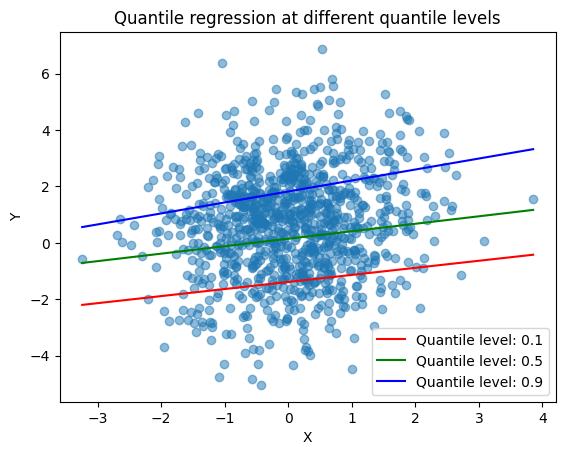

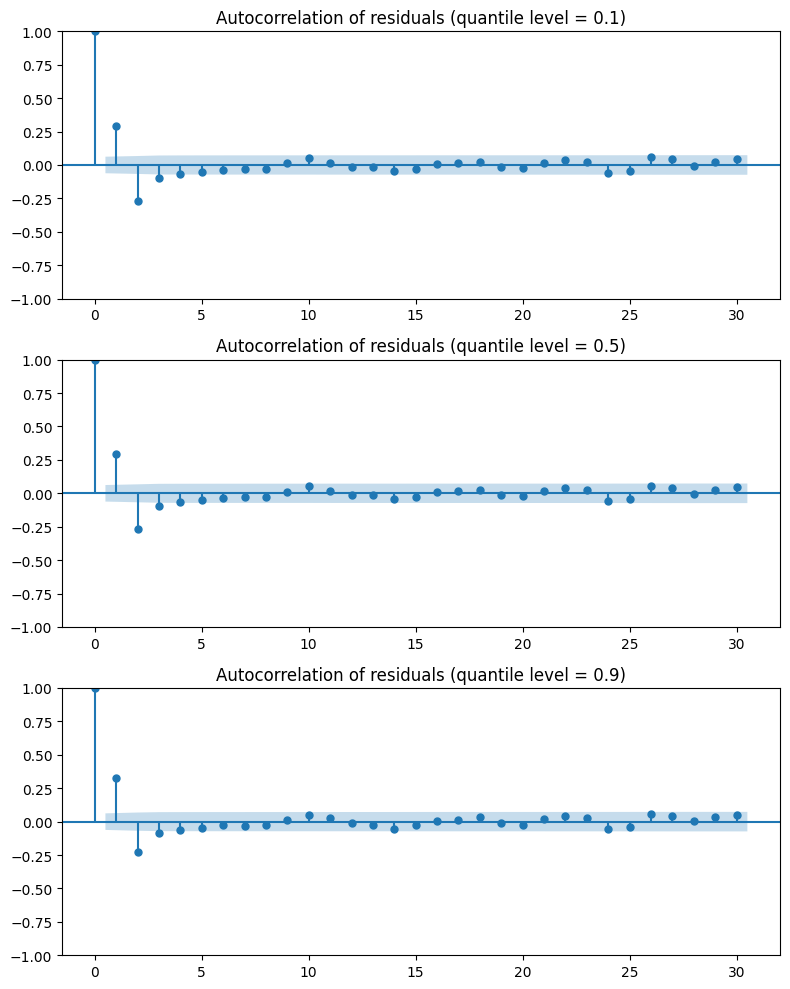

(<class 'statsmodels.iolib.summary.Summary'>
 """
                          QuantReg Regression Results                          
 Dep. Variable:                      y   Pseudo R-squared:               0.3451
 Model:                       QuantReg   Bandwidth:                      0.4867
 Method:                 Least Squares   Sparsity:                        7.633
 Date:                Sat, 01 Jul 2023   No. Observations:                 1000
 Time:                        15:30:51   Df Residuals:                      997
                                         Df Model:                            2
                  coef    std err          t      P>|t|      [0.025      0.975]
 ------------------------------------------------------------------------------
 const         -1.3888      0.078    -17.845      0.000      -1.542      -1.236
 x1             0.7595      0.040     18.828      0.000       0.680       0.839
 x2             0.2507      0.077      3.277      0.001       0.101   

In [52]:
################################ Quantile linear regression with package ################################
def fit_quantile(df):
    
    y = df['y'].values.astype(float)
    x = df['x'].values.astype(float)
    y_lag = np.roll(y, 1)
    y_lag[0] = 0
    
    X = np.column_stack((np.ones_like(x), y_lag, x))

    quant_reg_1 = sm.QuantReg(y, X).fit(q=0.1)
    quant_reg_5 = sm.QuantReg(y, X).fit(q=0.5)
    quant_reg_9 = sm.QuantReg(y, X).fit(q=0.9)

    # Plot the scatter data and the quantile regression lines
    fig, ax = plt.subplots()
    ax.scatter(x, y, alpha=0.5)

    # Generate x values for the regression lines
    x_vals = np.linspace(np.min(x), np.max(x), 250)

    # Plot the regression lines
    ax.plot(x_vals, quant_reg_1.params[0] + quant_reg_1.params[1]*0 + quant_reg_1.params[2]*x_vals, 'r', label='Quantile level: 0.1')
    ax.plot(x_vals, quant_reg_5.params[0] + quant_reg_5.params[1]*0 + quant_reg_5.params[2]*x_vals, 'g', label='Quantile level: 0.5')
    ax.plot(x_vals, quant_reg_9.params[0] + quant_reg_9.params[1]*0 + quant_reg_9.params[2]*x_vals, 'b', label='Quantile level: 0.9')

    # Add a legend and labels to the plot
    ax.legend()
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_title('Quantile regression at different quantile levels')

    plt.show()

################################ Autocorrelation of the residuals ##############################
    residuals_1 = quant_reg_1.resid # Calculate the residuals
    residuals_5 = quant_reg_5.resid # Calculate the residuals
    residuals_9 = quant_reg_9.resid # Calculate the residuals

    # Plot the autocorrelation function of the residuals for all three quantile regression models in one plot
    fig, ax = plt.subplots(3, 1, figsize=(8, 10))
    plot_acf(quant_reg_1.resid, ax=ax[0])
    ax[0].set_title('Autocorrelation of residuals (quantile level = 0.1)')
    plot_acf(quant_reg_5.resid, ax=ax[1])
    ax[1].set_title('Autocorrelation of residuals (quantile level = 0.5)')
    plot_acf(quant_reg_9.resid, ax=ax[2])
    ax[2].set_title('Autocorrelation of residuals (quantile level = 0.9)')
    plt.tight_layout()
    plt.show()

    return quant_reg_1.summary(), quant_reg_5.summary(), quant_reg_9.summary()

fit_quantile(df)

In [5]:
actuals = np.array([0.2, 0.5, 0.3])
beta_pac1 = np.array([-2.2763, 0.5197, 0.3564])  
beta_pac5 = np.array([0.2388, 0.5780, 0.3056])  
beta_pac9 = np.array([2.7531, 0.5675, 0.2313])    # True parameters alpha, beta, gamma, theta
  # Calculate the biases
biases_ols = actuals - np.array(beta_pac1)
for i, bias in enumerate(biases_ols):
    print(f"OLS_bias_param_{i} = {bias:.4f}")
    
mse_ols = np.mean(np.square(biases_ols)) # Calculate RMSE
rmse_ols = np.sqrt(mse_ols)
print(f"OLS_RMSE = {rmse_ols:.4f}")
    
biases_gls = actuals - np.array(beta_pac5) # Calculate the biases
for i, bias in enumerate(biases_gls):
    print(f"GLS_bias_param_{i} = {bias:.4f}")
    
mse_gls = np.mean(np.square(biases_gls)) # Calculate RMSE
rmse_gls = np.sqrt(mse_gls)
print(f"GLS_RMSE = {rmse_gls:.4f}")

biases_gls = actuals - np.array(beta_pac9) # Calculate the biases
for i, bias in enumerate(biases_gls):
    print(f"GLS_bias_param_{i} = {bias:.4f}")
    
mse_gls = np.mean(np.square(biases_gls)) # Calculate RMSE
rmse_gls = np.sqrt(mse_gls)
print(f"GLS_RMSE = {rmse_gls:.4f}")


OLS_bias_param_0 = 2.4763
OLS_bias_param_1 = -0.0197
OLS_bias_param_2 = -0.0564
OLS_RMSE = 1.4301
GLS_bias_param_0 = -0.0388
GLS_bias_param_1 = -0.0780
GLS_bias_param_2 = -0.0056
GLS_RMSE = 0.0504
GLS_bias_param_0 = -2.5531
GLS_bias_param_1 = -0.0675
GLS_bias_param_2 = 0.0687
GLS_RMSE = 1.4751


In [10]:
y = df['y'].values.astype(float)
x = df['x'].values.astype(float)
y_lag = np.roll(y, 1)
y_lag[0] = 0
X = np.column_stack((np.ones_like(x), y_lag, x))
beta_pac1 = np.array([-2.2763, 0.5197, 0.3564])  
beta_pac5 = np.array([0.2388, 0.5780, 0.3056])  
beta_pac9 = np.array([2.7531, 0.5675, 0.2313])  
ε = y - X @ beta_pac9
ε = ε.reshape((-1, 1))
ε_lag = np.roll(ε, 1)
ε_lag[0] = 0
ε_lag = ε_lag.reshape((-1, 1))
theta_hat = np.linalg.inv(ε_lag.T @ ε_lag) @ ε_lag.T @ ε
print(theta_hat)

[[0.87735687]]


In [ ]:
#True
#p=0.1 -0.2, 0.3, 0.2, 0.9
#p=0.5 0.2, 0.5, 0.3, 0.9
#p=0.9 0.6, 0.7, 0.4, 0.9

#Package
#p=0.1 -2.2763, 0.5197, 0.3564    
#p=0.5 0.2388, 0.5780, 0.3056
#p=0.9 2.7531, 0.5675, 0.2313  

In [55]:
def ols_gls_estimationM(df, M, initial_params):
    df = df.astype('float64') # convert data to float64 data type
    y_dataset = df['y'].values
    T = min(M, len(y_dataset))
    y = df['y'].values[:T]
    x = df['x'].values[:T]  # extract data
    #epsilon_y = df['epsilon_y'].values[:T]

    ols_alpha_hat = []
    ols_beta_hat = []
    ols_gamma_hat = []
    ols_theta_hat = []
    gls_alpha_hat = []
    gls_beta_hat = []
    gls_gamma_hat = []
    gls_theta_hat = []

    np.random.seed(123)
    for i in range(M):
        #epsilon = np.random.normal(T)  # Generate new errors for each iteration
        epsilon = np.random.randn(T) # Generate new errors for each iteration

        y = y + epsilon  # Update y with new errors

        # OLS estimation of the parameters
        y_lag = np.roll(y, 1)
        y_lag[0] = 0
        epsilon_lag = np.roll(epsilon, 1)
        epsilon_lag[0] = 0
        X = np.column_stack((np.ones_like(x), y_lag, x))
        beta_hat = np.linalg.inv(X.T @ X) @ X.T @ y
    
        ε = y - X @ beta_hat
        ε = ε.reshape((-1, 1))
        ε_lag = np.roll(ε, 1)
        ε_lag[0] = 0
        ε_lag = ε_lag.reshape((-1, 1))
        theta_hat = np.linalg.inv(ε.T @ ε_lag) @ ε_lag.T @ ε
        beta_hat = np.concatenate((beta_hat, [theta_hat[0, 0]]))

        acf_resid, ci = sm.tsa.stattools.acf(ε, nlags=50, alpha=0.05)
        sigma2 = np.var(ε) * (1 - acf_resid[1])
        sigma2_array = np.full(T, sigma2)
        rho = acf_resid[1] / (1 - acf_resid[1])
        S = np.diag(sigma2_array) + rho * np.diag(np.sqrt(sigma2_array[:-1] * sigma2_array[1:]), k=1) + rho * np.diag(np.sqrt(sigma2_array[:-1] * sigma2_array[1:]), k=-1)
        beta_gls = np.linalg.inv(X.T @ np.linalg.inv(S) @ X) @ X.T @ np.linalg.inv(S) @ y
        theta_gls = np.linalg.inv(ε.T @ np.linalg.inv(S) @ ε_lag) @ ε_lag.T @ np.linalg.inv(S) @ ε
        beta_gls = np.concatenate((beta_gls, [theta_gls[0, 0]]))

        # Store parameter estimates
        ols_alpha_hat.append(beta_hat[0])
        ols_beta_hat.append(beta_hat[1])
        ols_gamma_hat.append(beta_hat[2])
        ols_theta_hat.append(theta_hat[0, 0])
        gls_alpha_hat.append(beta_gls[0])
        gls_beta_hat.append(beta_gls[1])
        gls_gamma_hat.append(beta_gls[2])
        gls_theta_hat.append(theta_gls[0, 0])

        # Check convergence to initial parameters
        if np.allclose([ols_alpha_hat[-1], ols_beta_hat[-1], ols_gamma_hat[-1], ols_theta_hat[-1], gls_alpha_hat[-1], gls_beta_hat[-1], gls_gamma_hat[-1], gls_theta_hat[-1]], initial_params):
            print("Converged after {} iterations".format(_+1))
        break

    # Print or perform further analysis using the stored parameter estimates
    print("Parameter estimates:")
    print("OLS alpha_hat: ", ols_alpha_hat)
    print("OLS beta_hat: ", ols_beta_hat)
    print("OLS gamma_hat: ", ols_gamma_hat)
    print("OLS theta_hat: ", ols_theta_hat)
    print("GLS alpha_hat: ", gls_alpha_hat)
    print("GLS beta_hat: ", gls_beta_hat)
    print("GLS gamma_hat: ", gls_gamma_hat)
    print("GLS theta_hat: ", gls_theta_hat)


    actuals = np.array([0.2, 0.5, 0.3, 0.9])  # True parameters alpha, beta, gamma, theta
  # Calculate the biases
    biases_ols = actuals - np.array(beta_hat)
    for i, bias in enumerate(biases_ols):
        print(f"OLS_bias_param_{i} = {bias:.4f}")
    
    mse_ols = np.mean(np.square(biases_ols)) # Calculate RMSE
    rmse_ols = np.sqrt(mse_ols)
    print(f"OLS_RMSE = {rmse_ols:.4f}")
    
    biases_gls = actuals - np.array(beta_gls) # Calculate the biases
    for i, bias in enumerate(biases_gls):
        print(f"GLS_bias_param_{i} = {bias:.4f}")
    
    mse_gls = np.mean(np.square(biases_gls)) # Calculate RMSE
    rmse_gls = np.sqrt(mse_gls)
    print(f"GLS_RMSE = {rmse_gls:.4f}")


In [43]:
def ols_gls_estimationM(df, M, initial_params):
    df = df.astype('float64') # convert data to float64 data type
    y_dataset = df['Y'].values
    T = min(M, len(y_dataset))
    y = df['Y'].values[:T]
    x = df['X'].values[:T]  # extract data
    
    ols_alpha_hat = []
    ols_beta_hat = []
    ols_gamma_hat = []
    ols_theta_hat = []
    gls_alpha_hat = []
    gls_beta_hat = []
    gls_gamma_hat = []
    gls_theta_hat = []
    y_new = np.zeros(M+1)
    y_new[0] = y[0]

    beta = 0.5
    gamma = 0.3
    
    np.random.seed(123)

    for i in range(1, M+1):  
        epsilon = np.random.randn(T)
        for j in range(T):
            y_new[j] = beta * y_new[j-1] + gamma * x[j] + epsilon[j]

        # OLS estimation of the parameters
        y_lag = np.roll(y_new, 1)
        y_lag[0] = 0
        epsilon_lag = np.roll(epsilon, 1)
        epsilon_lag[0] = 0
        y_lag = y_lag[:T]
        X = np.column_stack((np.ones_like(x)[:T], y_lag, x))
        beta_hat = np.linalg.inv(X.T @ X) @ X.T @ y

        ε = y - X @ beta_hat
        ε = ε.reshape((-1, 1))
        ε_lag = np.roll(ε, 1)
        ε_lag[0] = 0
        ε_lag = ε_lag.reshape((-1, 1))
        theta_hat = np.linalg.inv(ε.T @ ε_lag) @ ε_lag.T @ ε
        beta_hat = np.concatenate((beta_hat, [theta_hat[0, 0]]))

        acf_resid, ci = sm.tsa.stattools.acf(ε, nlags=50, alpha=0.05)
        sigma2 = np.var(ε) * (1 - acf_resid[1])
        sigma2_array = np.full(T, sigma2)
        rho = acf_resid[1] / (1 - acf_resid[1])
        S = np.diag(sigma2_array) + rho * np.diag(np.sqrt(sigma2_array[:-1] * sigma2_array[1:]), k=1) + rho * np.diag(np.sqrt(sigma2_array[:-1] * sigma2_array[1:]), k=-1)
        beta_gls = np.linalg.inv(X.T @ np.linalg.inv(S) @ X) @ X.T @ np.linalg.inv(S) @ y
        theta_gls = np.linalg.inv(ε.T @ np.linalg.inv(S) @ ε_lag) @ ε_lag.T @ np.linalg.inv(S) @ ε
        beta_gls = np.concatenate((beta_gls, [theta_gls[0, 0]]))

        # Store parameter estimates
        ols_alpha_hat.append(beta_hat[0])
        ols_beta_hat.append(beta_hat[1])
        ols_gamma_hat.append(beta_hat[2])
        ols_theta_hat.append(theta_hat[0, 0])
        gls_alpha_hat.append(beta_gls[0])
        gls_beta_hat.append(beta_gls[1])
        gls_gamma_hat.append(beta_gls[2])
        gls_theta_hat.append(theta_gls[0, 0])

        # Check convergence to initial parameters
        if np.allclose([ols_alpha_hat[-1], ols_beta_hat[-1], ols_gamma_hat[-1], ols_theta_hat[-1], gls_alpha_hat[-1], gls_beta_hat[-1], gls_gamma_hat[-1], gls_theta_hat[-1]], initial_params):
            print("Converged after {} iterations".format(_+1))
        break

    # Calculate means
    ols_alpha_mean = np.mean(ols_alpha_hat)
    ols_beta_mean = np.mean(ols_beta_hat)
    ols_gamma_mean = np.mean(ols_gamma_hat)
    ols_theta_mean = np.mean(ols_theta_hat)
    gls_alpha_mean = np.mean(gls_alpha_hat)
    gls_beta_mean = np.mean(gls_beta_hat)
    gls_gamma_mean = np.mean(gls_gamma_hat)
    gls_theta_mean = np.mean(gls_theta_hat)

    # Print or perform further analysis using the means
    print("Parameter means:")
    print("OLS alpha_mean:", ols_alpha_mean)
    print("OLS beta_mean:", ols_beta_mean)
    print("OLS gamma_mean:", ols_gamma_mean)
    print("OLS theta_mean:", ols_theta_mean)
    print("GLS alpha_mean:", gls_alpha_mean)
    print("GLS beta_mean:", gls_beta_mean)
    print("GLS gamma_mean:", gls_gamma_mean)
    print("GLS theta_mean:", gls_theta_mean)
    
    # Return means as a dictionary if needed
    means = {
        "ols_alpha_mean": ols_alpha_mean,
        "ols_beta_mean": ols_beta_mean,
        "ols_gamma_mean": ols_gamma_mean,
        "ols_theta_mean": ols_theta_mean,
        "gls_alpha_mean": gls_alpha_mean,
        "gls_beta_mean": gls_beta_mean,
        "gls_gamma_mean": gls_gamma_mean,
        "gls_theta_mean": gls_theta_mean
    }
    
    return means


In [56]:
M=1000
initial_params = 0.2, 0.5, 0.3, 0.9, 0.2, 0.5, 0.3, 0.9
ols_gls_estimationM(df, M, initial_params)

Parameter estimates:
OLS alpha_hat:  [0.25447061320741066]
OLS beta_hat:  [0.5900422629395783]
OLS gamma_hat:  [0.2512666211612553]
OLS theta_hat:  [0.9999999999999994]
GLS alpha_hat:  [0.27438451057842206]
GLS beta_hat:  [0.5585761912495335]
GLS gamma_hat:  [0.25306784029104556]
GLS theta_hat:  [1.000000000000221]
OLS_bias_param_0 = -0.0545
OLS_bias_param_1 = -0.0900
OLS_bias_param_2 = 0.0487
OLS_bias_param_3 = -0.1000
OLS_RMSE = 0.0766
GLS_bias_param_0 = -0.0744
GLS_bias_param_1 = -0.0586
GLS_bias_param_2 = 0.0469
GLS_bias_param_3 = -0.1000
GLS_RMSE = 0.0727


In [293]:
M=250
initial_params = 0.2, 0.5, 0.3, 0.9, 0.2, 0.5, 0.3, 0.9
ols_gls_estimationM(df, M, initial_params)

Parameter estimates:
OLS alpha_hat:  [-0.3814009294589638]
OLS beta_hat:  [0.1798020249981496]
OLS gamma_hat:  [0.198318148873324]
OLS theta_hat:  [1.0000000000000009]
GLS alpha_hat:  [-0.3869920379853143]
GLS beta_hat:  [0.1679111132799943]
GLS gamma_hat:  [0.19795413386903146]
GLS theta_hat:  [1.0000000000000018]
OLS_bias_param_0 = 0.5814
OLS_bias_param_1 = 0.3202
OLS_bias_param_2 = 0.1017
OLS_bias_param_3 = -0.1000
OLS_RMSE = 0.3394
GLS_bias_param_0 = 0.5870
GLS_bias_param_1 = 0.3321
GLS_bias_param_2 = 0.1020
GLS_bias_param_3 = -0.1000
GLS_RMSE = 0.3447


In [294]:
M=1000
initial_params = 0.2, 0.5, 0.3, 0.9, 0.2, 0.5, 0.3, 0.9
ols_gls_estimationM(df, M, initial_params)

Parameter estimates:
OLS alpha_hat:  [0.2526742480462547]
OLS beta_hat:  [0.45893765600712555]
OLS gamma_hat:  [0.35538915887210537]
OLS theta_hat:  [0.9999999999999997]
GLS alpha_hat:  [0.23859574007303636]
GLS beta_hat:  [0.4888490777272514]
GLS gamma_hat:  [0.3565230198709536]
GLS theta_hat:  [1.000000000000002]
OLS_bias_param_0 = -0.0527
OLS_bias_param_1 = 0.0411
OLS_bias_param_2 = -0.0554
OLS_bias_param_3 = -0.1000
OLS_RMSE = 0.0662
GLS_bias_param_0 = -0.0386
GLS_bias_param_1 = 0.0112
GLS_bias_param_2 = -0.0565
GLS_bias_param_3 = -0.1000
GLS_RMSE = 0.0608


In [19]:
y = df['Y'].values.astype(float)
x = df['X'].values.astype(float)
y_lag = np.roll(y, 1)
y_lag[0] = 0
X = np.column_stack((np.ones_like(x), y_lag, x))
beta_ols1 = np.array([-0.439, 0.208, 0.083])  #100
beta_ols2 = np.array([-0.381, 0.180, 0.198])  #250
beta_ols0 = np.array([0.253, 0.459, 0.355])  #1000
ε = y - X @ beta_ols0
ε = ε.reshape((-1, 1))
ε_lag = np.roll(ε, 1)
ε_lag[0] = 0
ε_lag = ε_lag.reshape((-1, 1))
theta_hat = np.linalg.inv(ε_lag.T @ ε_lag) @ ε_lag.T @ ε
print(theta_hat)

[[0.99710374]]


In [22]:
y = df['Y'].values.astype(float)
x = df['X'].values.astype(float)
y_lag = np.roll(y, 1)
y_lag[0] = 0
X = np.column_stack((np.ones_like(x), y_lag, x))
beta_gls1 = np.array([-0.455, 0.178, 0.079])  #100
beta_gls2 = np.array([-0.387, 0.168, 0.198])  #250
beta_gls0 = np.array([0.239, 0.488, 0.357])  #1000
ε = y - X @ beta_gls0
ε = ε.reshape((-1, 1))
ε_lag = np.roll(ε, 1)
ε_lag[0] = 0
ε_lag = ε_lag.reshape((-1, 1))
theta_hat = np.linalg.inv(ε_lag.T @ ε_lag) @ ε_lag.T @ ε
print(theta_hat)

[[0.99659907]]


In [23]:
def Laplace_estimation(df, p, M, params0, actuals):

    df = df.astype('float64') # convert data to float64 data type
    y_dataset = df['Y'].values
    T = min(M, len(y_dataset))
    y = df['Y'].values[:T]
    x = df['X'].values[:T]  # extract data
    y = y.reshape(-1)
    beta_matrix = np.zeros((M, 3))  # Empty matrix to store beta parameters
    rmse_matrix = np.zeros((M, 3))  # Empty matrix to store RMSE values
    success_count = 0
    failure_count = 0

    def log_l_Asym_Lap(params, X, y):
        α, β, γ = params  # Separate the parameters
        ll = 0 
        z = np.random.exponential(1, T)
        τ_2 = 2 / p * (1 - p)
        τ = np.sqrt(2 / p * (1 - p))
        θ = (1 - 2 * p) / p * (1 - p)
        
        # Calculate the log-likelihood
        ll -= np.sum(np.log(np.sqrt(1/z)) + 0.5 * ((y - α - β * X[:, 1] - γ * X[:, 2]) ** 2) / (τ_2 * z))
        #ll -= np.sum(np.log(z)) +  np.sum(((y - α - β * X[:, 1] - γ * X[:, 2]) ** 2)/ (τ_2 * z))
        return -ll

    np.random.seed(123)
    for i in range(M):
        epsilon = laplace_asymmetric.rvs(kappa=0.5, loc=0, scale=1, size=T) # Generate new errors for each iteration
        y_updated = y + epsilon  # Update y with new errors
        y_lag = np.roll(y_updated, 1)
        y_lag[0] = 0
        y_lag = y_lag.reshape((-1, 1))
        X = np.column_stack((np.ones_like(x), y_lag, x))
        
        res = optimize.minimize(log_l_Asym_Lap, params0, args=(X, y), method='Powell')  # minimize the negative log-likelihood #method='Powell'
        beta_laplace = res.x # the estimated beta is in res.x
        succ = res.success

        beta_matrix[i, :] = beta_laplace  # Store beta parameters in the matrix

        if succ:
            success_count += 1
        else:
            failure_count += 1
        
        biases = actuals - np.array(beta_laplace)
        mse = np.mean(np.square(biases))  # Calculate MSE
        rmse = np.sqrt(mse)  # Calculate RMSE
        rmse_matrix[i, :] = rmse  # Store RMSE values in the matrix

    print("Beta Matrix:")
    print(beta_matrix)
    print("\nRMSE Matrix:")
    print(rmse_matrix)
    print("\nSuccessful optimizations: {}".format(success_count))
    print("Unsuccessful optimizations: {}".format(failure_count))
    print("\nMean of Betas:")
    print(np.mean(beta_matrix, axis=0))
    print("\nMean of RMSE:")
    print(np.mean(rmse_matrix))

    return beta_matrix


In [26]:
#Estimation at p=0.5 and T=100
params0 = np.array([0.15, 0.45, 0.25], dtype=float) 
actuals = np.array([0.2, 0.5, 0.3])
result_matrix = Laplace_estimation(df, 0.5, 100, params0, actuals)

Beta Matrix:
[[-6.28448680e-01  7.55806120e-01  2.00733357e+00]
 [-1.61393204e+00  1.40925855e-01 -1.89764809e-01]
 [-1.53249296e+00  4.70388635e-01  2.12754120e+00]
 [-1.86887766e-01  4.82239831e-01  1.17176385e+00]
 [ 8.43045460e-01 -1.25120604e+00  2.71192855e+00]
 [ 1.82922150e+00 -2.36917682e-01  4.94198592e-01]
 [ 1.06404180e+00  5.79815644e-01 -5.12622867e-01]
 [-2.22309876e-01 -5.64642233e-01 -7.49999984e-01]
 [ 1.20572809e+00  6.40789966e-01  2.26940456e+00]
 [-4.08550556e-01 -4.27255611e-01  7.51112692e-01]
 [ 1.65051945e+00  1.03229073e+00  2.86803400e+00]
 [ 7.68034000e-01  6.00512465e-01  1.25000000e+00]
 [-1.90379551e+00  1.91306402e-01  3.48606800e+00]
 [ 1.15000000e+00 -1.68033975e-01  5.76237915e-01]
 [-5.05948897e-01  8.87412122e-01 -1.09542416e+00]
 [-8.64531515e-01  7.76237940e-01  1.24999990e+00]
 [-9.85486116e-02  7.44218582e-02 -1.44512659e+00]
 [ 9.87612840e-01 -4.51987099e-01  2.14959019e-03]
 [ 7.68033990e-01 -4.63307434e-01  1.86803397e+00]
 [ 6.60048873e-01 

In [27]:
#Estimation at p=0.5 and T=250
params0 = np.array([0.15, 0.45, 0.35], dtype=float) 
actuals = np.array([0.2, 0.5, 0.3])
result_matrix = Laplace_estimation(df, 0.5, 250, params0, actuals)

Beta Matrix:
[[ 4.20614351e-01  3.12945357e-01  2.31529595e+00]
 [-1.48540106e+00 -4.55961076e-01  1.45611631e+00]
 [ 1.47821079e-01  4.35720011e-01  2.35000003e+00]
 [-4.69867181e-01  4.52693467e-01  9.72286388e-01]
 [ 8.23471448e-01 -1.73058973e-01  1.77089330e+00]
 [ 1.31236250e+00  4.81759242e-01  1.11393203e+00]
 [-1.41278567e-02  3.68842530e-01  1.56048988e+00]
 [ 1.49999975e-01  2.72910742e-02  9.68308586e-01]
 [ 1.76803397e+00 -1.16803400e+00  3.80352731e-01]
 [-8.50000157e-01  4.36628172e-01 -3.19660252e-02]
 [ 8.13967828e-01 -1.68033975e-01 -1.32376208e+00]
 [ 1.44824184e+00  1.27289985e+00  2.27024088e+00]
 [ 1.29006572e+00 -2.84239281e-01  1.02523193e+00]
 [-1.31557416e+00  1.09285169e+00 -1.56577800e-01]
 [ 5.41270348e-01 -1.72002148e-01  1.35620640e+00]
 [-2.09721880e+00  6.70323207e-01  9.25710698e-01]
 [ 3.86067965e-01  1.45000000e+00  1.58606797e+00]
 [-5.67923708e-01  2.52745920e-01 -2.34203056e-01]
 [-5.67250364e-01 -1.29708697e-01  1.91230588e+00]
 [ 1.24997452e+00 

In [24]:
#Estimation at p=0.5 and T=1000  #Package #p=0.5 0.2388, 0.5780, 0.3056
params0 = np.array([0.2, 0.5, 0.3], dtype=float) 
actuals = np.array([0.2, 0.5, 0.3])
result_matrix = Laplace_estimation(df, 0.5, 1000, params0, actuals)

Beta Matrix:
[[-0.51910652  0.63311827  0.83964579]
 [ 0.19231454  0.39367922  2.71071576]
 [-0.28175146  0.09551938  2.03464673]
 ...
 [ 1.05410197  0.20518012 -1.01957171]
 [ 0.59826154  2.01077066  0.99410074]
 [ 0.08258649  0.25981535 -0.70005053]]

RMSE Matrix:
[[0.52473874 0.52473874 0.52473874]
 [1.39318743 1.39318743 1.39318743]
 [1.06531502 1.06531502 1.06531502]
 ...
 [0.92334148 0.92334148 0.92334148]
 [0.98705219 0.98705219 0.98705219]
 [0.59765532 0.59765532 0.59765532]]

Successful optimizations: 1000
Unsuccessful optimizations: 0

Mean of Betas:
[0.28153525 0.32935577 0.77615152]

Mean of RMSE:
0.828725117680566


In [28]:
#Estimation at p=0.1 and T=100
params0 = np.array([-0.2, 0.3, 0.2], dtype=float)  #-0.2, 0.3, 0.2
actuals = np.array([-0.2, 0.3, 0.2])
result_matrix = Laplace_estimation(df, 0.1, 100, params0, actuals)

Beta Matrix:
[[ 3.90723651e-01  8.25124806e-01 -1.64970808e-01]
 [ 8.23923255e-01  1.61667101e-01  2.05410197e+00]
 [-3.24698201e-01 -8.29634653e-02  1.87376206e+00]
 [ 1.81966000e-01  5.07817352e-02 -1.11794729e+00]
 [-9.31152624e-01  2.58597536e-03  1.57544081e+00]
 [-2.00000025e-01  3.49730447e-01  1.57997282e+00]
 [-2.00125741e-01 -5.32815706e-01  1.43606800e+00]
 [ 1.88146365e-01  4.07651821e-01  5.25522882e-01]
 [ 9.22761633e-01  7.32435066e-01 -2.07155191e+00]
 [-1.51821972e+00  2.94410786e-01  8.55874809e-01]
 [-1.70529984e+00  1.17538818e+00  2.43606797e+00]
 [-8.47926309e-01  9.06075685e-02 -1.04567514e+00]
 [ 1.41803397e+00 -7.26539974e-02  5.85785660e-01]
 [-1.10085130e+00  2.16894344e-01  1.20000000e+00]
 [-4.83665487e-01  5.67922405e-01  2.40296853e-02]
 [ 3.27864035e-01  6.39153640e-02  3.82457080e-01]
 [ 3.37514599e-01  1.85439089e-02 -1.43299646e-01]
 [ 1.41803397e+00 -4.55801386e-01  3.81915558e-02]
 [-8.67024441e-01  1.34032087e+00  5.44824050e-01]
 [-2.82421431e+00 

In [297]:
#Estimation at p=0.1 and T=250
params0 = np.array([-0.2, 0.3, 0.2], dtype=float) 
actuals = np.array([-0.2, 0.3, 0.2])
result_matrix = Laplace_estimation(df, 0.1, 250, params0, actuals)

Beta Matrix:
[[-9.71419082e-03  3.85523805e-02  8.71839597e-01]
 [-1.76766739e+00  1.25900961e-01 -8.05024982e-01]
 [-7.62305890e-01  5.60459845e-01 -1.73450805e-01]
 [-1.24192544e+00  1.25300350e-01  2.35627816e-01]
 [-6.11648232e-01 -1.66666439e-02  1.50489969e+00]
 [ 5.79021532e-01  1.19295483e+00  1.77881523e-01]
 [-4.27933757e-01 -1.37039942e-01  1.45995336e+00]
 [ 1.17814634e+00 -1.14241853e-01  1.17428197e+00]
 [ 8.00000000e-01  3.00025251e-01  2.34441851e-01]
 [-1.34524023e+00 -5.09827944e-02 -4.12884292e-01]
 [ 1.43337216e-01 -6.56653816e-01  1.87237233e-01]
 [ 1.89762603e-01  4.69835194e-01  6.16877670e-01]
 [ 9.21059228e-01  3.26493263e-01  1.64701279e+00]
 [ 8.39811788e-01 -6.31096903e-02 -1.32786402e+00]
 [ 2.50417869e-01  8.94130257e-02  2.43391364e-01]
 [-2.00008505e-01 -5.79460004e-02  2.25572807e+00]
 [ 5.88127111e-01  2.07890644e-01  7.03698721e-01]
 [ 1.76513079e-01 -2.40262696e-01  1.84393246e-01]
 [-1.65944939e-01  2.81347546e-01  2.35617660e+00]
 [ 1.49657857e+00 

In [298]:
#Estimation at p=0.1 and T=1000
params0 = np.array([-0.2, 0.3, 0.2], dtype=float) 
actuals = np.array([-0.2, 0.3, 0.2])
result_matrix = Laplace_estimation(df, 0.1, 1000, params0, actuals)

Beta Matrix:
[[-0.34870552  1.50414614  1.43609851]
 [-0.68544274 -0.20541879  0.81185366]
 [-0.19999913 -0.24757633  1.83932021]
 ...
 [-0.0134605   0.36622531  1.2       ]
 [-0.81803397  0.20529875  1.81640524]
 [-1.47957388  0.44397865  2.41988768]]

RMSE Matrix:
[[1.00000346 1.00000346 1.00000346]
 [0.53711194 0.53711194 0.53711194]
 [0.99786615 0.99786615 0.99786615]
 ...
 [0.58855268 0.58855268 0.58855268]
 [1.00061651 1.00061651 1.00061651]
 [1.48165903 1.48165903 1.48165903]]

Successful optimizations: 1000
Unsuccessful optimizations: 0

Mean of Betas:
[0.2416541  0.30289202 0.7183746 ]

Mean of RMSE:
0.7805501233128389


In [299]:
#Estimation at p=0.9 and T=100
params0 = np.array([0.6, 0.7, 0.4,], dtype=float) 
actuals = np.array([0.6, 0.7, 0.4,])
result_matrix = Laplace_estimation(df, 0.9, 100, params0, actuals)

Beta Matrix:
[[ 7.82077185e-02  8.45898025e-01  1.01803400e+00]
 [-1.53301694e+00  1.05600583e+00  3.55727401e-01]
 [ 1.18356593e+00  5.97150476e-01  8.80571789e-01]
 [ 1.40408628e+00  1.11640785e+00 -2.18033975e-01]
 [ 2.21803400e+00  1.31802651e+00  2.90413553e+00]
 [-2.62355501e-01 -5.95162201e-01  2.22513578e-01]
 [ 6.10000027e-01 -1.13255440e-01 -1.66727449e-01]
 [-4.45114213e-01  2.37376206e+00 -2.04878359e-01]
 [ 1.20733515e+00  6.01320399e-01  1.71212354e+00]
 [ 1.61696259e+00  7.00000000e-01  3.10491418e+00]
 [ 1.60000000e+00  1.51078506e+00  4.04457230e-01]
 [ 6.00000000e-01  8.13722483e-02  1.00688055e+00]
 [ 5.58017234e-01  7.77513738e-01  1.62869753e+00]
 [-1.01684774e+00  1.16727847e+00  1.42324093e+00]
 [ 9.77041962e-01 -5.25084449e-01  2.73858888e+00]
 [ 2.57370034e+00  4.71976722e-01 -2.94097391e-01]
 [ 1.29672388e+00  1.57861579e-01  1.53846591e+00]
 [ 1.39183381e+00 -1.19962556e-02  1.42370025e+00]
 [ 5.05600862e-01  8.63972846e-01  3.53114708e-01]
 [-2.71640040e+00 

In [284]:
#Estimation at p=0.9 and T=250
params0 = np.array([0.6, 0.7, 0.4,], dtype=float) 
actuals = np.array([0.6, 0.7, 0.4,])
result_matrix = Laplace_estimation(df, 0.9, 250, params0, actuals)

Beta Matrix:
[[ 2.69016994e+00 -8.87933187e-02 -4.18733573e-01]
 [ 1.93302736e-01 -1.75202172e-01  1.41000251e+00]
 [ 1.53374380e+00  1.42354450e+00  1.40215756e+00]
 [-2.63606800e+00 -3.40900956e-01 -1.20012777e-02]
 [ 6.17556716e-01  1.01096301e+00  1.78196598e+00]
 [ 7.27091538e-01  7.00741715e-01  1.57914716e+00]
 [ 3.83606795e+00  1.66492240e+00  7.70739080e-01]
 [-2.63606796e+00  5.60415378e-01  1.08811421e-01]
 [ 3.03719868e+00 -2.73857799e-01  2.29853988e+00]
 [ 2.74589802e+00  7.67492515e-01  3.94975002e-01]
 [ 9.59359426e-01  7.00000016e-01 -7.27228635e-01]
 [-1.35795185e+00 -2.41158030e-01 -5.82566712e-01]
 [ 2.85842864e+00  1.31803400e+00  1.71358841e-01]
 [ 5.99999975e-01  1.19880234e-01 -7.98332282e-01]
 [ 1.92392606e-01  2.59563729e-01  2.51716345e+00]
 [-1.59016807e-01  5.18838083e-01 -2.23134696e-01]
 [ 9.32395232e-01  3.56234818e-02  2.13020979e+00]
 [ 2.99211398e+00 -9.18033950e-01  2.01591325e+00]
 [ 9.43839622e-01  3.59101146e-01  3.89428272e-01]
 [ 1.21803400e+00 

In [300]:
#Estimation at p=0.9 and T=1000
params0 = np.array([0.6, 0.7, 0.4,], dtype=float) 
actuals = np.array([0.6, 0.7, 0.4,])
result_matrix = Laplace_estimation(df, 0.9, 1000, params0, actuals)

Beta Matrix:
[[ 1.21803277  0.0946885   2.63606797]
 [ 0.60002525  0.48100974  2.4       ]
 [ 1.08352035  0.55872995  1.41245737]
 ...
 [ 0.46459558  0.60291451 -0.71136716]
 [ 1.21803399  0.12729389  1.44572809]
 [ 3.1116837   0.42695062  0.50714762]]

RMSE Matrix:
[[1.38424065 1.38424065 1.38424065]
 [1.16160187 1.16160187 1.16160187]
 [0.65289587 0.65289587 0.65289587]
 ...
 [0.64881865 0.64881865 0.64881865]
 [0.77535057 0.77535057 0.77535057]
 [1.45997621 1.45997621 1.45997621]]

Successful optimizations: 1000
Unsuccessful optimizations: 0

Mean of Betas:
[0.38784845 0.35755793 0.88250139]

Mean of RMSE:
0.9021693165071049


In [28]:
#p=0.1
y = df['Y'].values.astype(float)
x = df['X'].values.astype(float)
y_lag = np.roll(y, 1)
y_lag[0] = 0
X = np.column_stack((np.ones_like(x), y_lag, x))
beta_lap1 = np.array([-0.1813, 0.2830, 0.7807])  #100
beta_lap2 = np.array([-0.1316, 0.2303, 0.7816])  #250
beta_lap0 = np.array([0.2417, 0.3029, 0.7184])  #1000
ε = y - X @ beta_lap0
ε = ε.reshape((-1, 1))
ε_lag = np.roll(ε, 1)
ε_lag[0] = 0
ε_lag = ε_lag.reshape((-1, 1))
theta_hat = np.linalg.inv(ε_lag.T @ ε_lag) @ ε_lag.T @ ε
print(theta_hat)

[[0.98471361]]


In [32]:
#p=0.5
y = df['Y'].values.astype(float)
x = df['X'].values.astype(float)
y_lag = np.roll(y, 1)
y_lag[0] = 0
X = np.column_stack((np.ones_like(x), y_lag, x))
beta_lap1 = np.array([-0.0173, 0.2096, 0.9195])  #100
beta_lap2 = np.array([0.0488, 0.1830, 1.0153])  #250
beta_lap0 = np.array([0.2555, 0.3298, 0.7468])  #1000
ε = y - X @ beta_lap0
ε = ε.reshape((-1, 1))
ε_lag = np.roll(ε, 1)
ε_lag[0] = 0
ε_lag = ε_lag.reshape((-1, 1))
theta_hat = np.linalg.inv(ε_lag.T @ ε_lag) @ ε_lag.T @ ε
print(theta_hat)


[[0.98147767]]


In [35]:
#p=0.9
y = df['Y'].values.astype(float)
x = df['X'].values.astype(float)
y_lag = np.roll(y, 1)
y_lag[0] = 0
X = np.column_stack((np.ones_like(x), y_lag, x))
beta_lap1 = np.array([0.5226, 0.3203, 0.8794])  #100
beta_lap2 = np.array([0.2286, 0.2377, 0.9563])  #250
beta_lap0 = np.array([0.3878, 0.3576, 0.8825])  #1000
ε = y - X @ beta_lap0
ε = ε.reshape((-1, 1))
ε_lag = np.roll(ε, 1)
ε_lag[0] = 0
ε_lag = ε_lag.reshape((-1, 1))
theta_hat = np.linalg.inv(ε_lag.T @ ε_lag) @ ε_lag.T @ ε
print(theta_hat)
 

[[0.96562216]]


EM Algorithm

In [313]:
def EM_Algorithm(n, p, df, M, sigma_ini, Σ, β, alpha_prior, gamma_prior, actuals):
    random_subset = df.sample(n)
    y = random_subset['Y'].values
    x = random_subset['X'].values
    y = df['Y'].values
    x = df['X'].values
    y = np.array(y)
    x = np.array(x)
    T = len(x)
    β_values = np.zeros((1, 3))  # Array to store β parameters
    rmse_ = np.zeros((1, 3)) 
    τ_2 = 2 / (p * (1 - p))
    τ = np.sqrt(τ_2)
    θ = (1 - 2 * p) / (p * (1 - p))
    y_lag = np.roll(y, 1)
    y_lag[0] = 0
    y_lag = y_lag.reshape((-1, 1))
    y = y.reshape((-1, 1))
    X = np.column_stack((np.ones_like(x), y_lag, x))
    l = np.ones((len(x), 1))
    U = np.zeros((len(x), len(x)))
    l = l.reshape((-1, 1))
    np.fill_diagonal(Σ, sigma_ini)
    np.random.seed(42)
    z = np.random.exponential(1, T)

    # EM Algorithm iterations
    for i in range(M):
        alpha = alpha_prior + (3 * n / 2)
        #gamma
        res = np.zeros((len(x), 1))  # Initialize as zeros
        denomin = np.zeros((len(x), 1))  # Initialize as zeros
        for j in range(T):  
            res[j] = (y[j] - X[j] @ β - θ * z[j]) ** 2
            denomin[j] = (2 * z[j] * τ_2) + z[j]
        gamma = gamma_prior + np.sum(res) / np.sum(denomin)  # Sum the arrays

        #print('gamma:', gamma)
        mode_sigma = gamma / (alpha + 1)
        sigma = mode_sigma

        u = (sigma * τ_2 * z) ** -1
        np.fill_diagonal(U, u)

        r = θ / (sigma * τ_2)
        m_ = Σ @ ((X.T @ U) @ y) - ((r) * (X.T @ l))
        β = m_
        abso = np.zeros((len(x), 1))
        for j in range(T):  
            abso[j] = np.abs(y[j] - X[j] @ β)
        μ = np.sqrt(θ ** 2 + 2 * τ_2) / (np.sum(abso))
        #print('μ:', μ)
        λ = (θ ** 2 + 2 * τ_2) / (sigma * τ_2)
        mode_z_inverse = μ * (np.sqrt(1 + (9 * (μ ** 2)) / (4 * (λ ** 2))) - (3 * μ) / (4 * λ))
        z_inverse = mode_z_inverse
        z[i+1] = 1 / mode_z_inverse
        #z[i+1] = mode_z_inverse
        #print('z[i+1]:', z[i+1])
        β_values = np.concatenate((β_values, β.flatten()[:len(x)].reshape(1, -1)), axis=0)  # Store β parameters
        Σ = np.linalg.inv((X.T @ U) @ X)
        print(f'Iteration {i+1}: {β_values[-1]}')  # Print the β parameters for each iteration

        biases = actuals - np.array(β)
        mse = np.mean(np.square(biases))  # Calculate MSE
        rmse = np.sqrt(mse)  # Calculate RMSE

        print("\nRMSE:")
        print(rmse)

        print("\nMean of RMSE:")
        print(np.mean(rmse))

    return β_values


In [314]:
#Package
#p=0.1 -2.2763, 0.5197, 0.3564    
#p=0.5 0.2388, 0.5780, 0.3056
#p=0.9 2.7531, 0.5675, 0.2313  
#True
#p=0.1 -0.2, 0.3, 0.2, 0.9
#p=0.5 0.2, 0.5, 0.3, 0.9
#p=0.9 0.6, 0.7, 0.4, 0.9


n = 100
p = 0.1
df = df.astype('float64')
M = 25 # Number of iterations
sigma_ini = 1.55
β = np.array([-2.2763, 0.5197, 0.3564]) #input result of OLS for p=0.1

Σ = np.zeros((3, 3))
alpha_prior = 3
gamma_prior = 0.5
actuals = np.array([-0.2, 0.3, 0.2])
EM_Algorithm(n, p, df, M, sigma_ini, Σ, β, alpha_prior, gamma_prior, actuals)

Iteration 1: [-9570.21754425 46852.73116071  3369.24666096]

RMSE:
27677.374477737063

Mean of RMSE:
27677.374477737063
Iteration 2: [-4.54223788e-03 -2.32011011e-03 -3.47334009e-05]

RMSE:
0.2390295883500494

Mean of RMSE:
0.2390295883500494
Iteration 3: [0.18677557 0.57129669 0.09854118]

RMSE:
0.35102359802421573

Mean of RMSE:
0.35102359802421573
Iteration 4: [0.18615317 0.57008243 0.09866089]

RMSE:
0.35042909536292227

Mean of RMSE:
0.35042909536292227
Iteration 5: [0.18611353 0.57022535 0.09936876]

RMSE:
0.350489093378608

Mean of RMSE:
0.350489093378608
Iteration 6: [0.18941324 0.57013319 0.0992405 ]

RMSE:
0.3507233103161743

Mean of RMSE:
0.3507233103161743
Iteration 7: [0.19187155 0.56891224 0.10254618]

RMSE:
0.35039289949086544

Mean of RMSE:
0.35039289949086544
Iteration 8: [0.18884319 0.57039193 0.09862414]

RMSE:
0.3507912833878517

Mean of RMSE:
0.3507912833878517
Iteration 9: [0.18895625 0.57033857 0.09885235]

RMSE:
0.35077670988260223

Mean of RMSE:
0.3507767098826

array([[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [-9.57021754e+03,  4.68527312e+04,  3.36924666e+03],
       [-4.54223788e-03, -2.32011011e-03, -3.47334009e-05],
       [ 1.86775574e-01,  5.71296691e-01,  9.85411760e-02],
       [ 1.86153171e-01,  5.70082430e-01,  9.86608942e-02],
       [ 1.86113527e-01,  5.70225346e-01,  9.93687640e-02],
       [ 1.89413243e-01,  5.70133190e-01,  9.92404952e-02],
       [ 1.91871552e-01,  5.68912238e-01,  1.02546184e-01],
       [ 1.88843185e-01,  5.70391931e-01,  9.86241426e-02],
       [ 1.88956250e-01,  5.70338569e-01,  9.88523496e-02],
       [ 1.88738922e-01,  5.70420137e-01,  9.85835245e-02],
       [ 1.80277288e-01,  5.59664260e-01,  8.81898462e-02],
       [ 1.91889469e-01,  5.74292418e-01,  1.02044245e-01],
       [ 1.91844958e-01,  5.74286340e-01,  1.02086124e-01],
       [ 1.92020285e-01,  5.74401703e-01,  1.02358278e-01],
       [ 1.95700264e-01,  5.74405368e-01,  1.02831556e-01],
       [ 1.99004607e-01,  5.72648633e-01

In [320]:
n = 250
p = 0.1
df = df.astype('float64')
M = 25 # Number of iterations
sigma_ini = 1.55
β = np.array([-2.2763, 0.5197, 0.3564]) #input result of OLS for p=0.1

Σ = np.zeros((3, 3))
alpha_prior = 3
gamma_prior = 0.5
actuals = np.array([-0.2, 0.3, 0.2])
EM_Algorithm(n, p, df, M, sigma_ini, Σ, β, alpha_prior, gamma_prior, actuals)

Iteration 1: [-23552.67824202 115306.3968176    8291.84730198]

RMSE:
68115.1684579526

Mean of RMSE:
68115.1684579526
Iteration 2: [-4.54190004e-03 -2.32000205e-03 -3.47439972e-05]

RMSE:
0.23902952515693188

Mean of RMSE:
0.23902952515693188
Iteration 3: [0.18677591 0.57129682 0.09854118]

RMSE:
0.35102368277632545

Mean of RMSE:
0.35102368277632545
Iteration 4: [0.18615353 0.57008257 0.09866087]

RMSE:
0.35042918806215756

Mean of RMSE:
0.35042918806215756
Iteration 5: [0.1861139  0.57022544 0.09936869]

RMSE:
0.3504891673123525

Mean of RMSE:
0.3504891673123525
Iteration 6: [0.18941358 0.57013329 0.09924042]

RMSE:
0.3507233832641099

Mean of RMSE:
0.3507233832641099
Iteration 7: [0.19187188 0.56891234 0.1025461 ]

RMSE:
0.350392971889568

Mean of RMSE:
0.350392971889568
Iteration 8: [0.18884353 0.57039211 0.0986241 ]

RMSE:
0.3507913945928144

Mean of RMSE:
0.3507913945928144
Iteration 9: [0.18895657 0.57033871 0.09885227]

RMSE:
0.35077679995684996

Mean of RMSE:
0.35077679995684

array([[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [-2.35526782e+04,  1.15306397e+05,  8.29184730e+03],
       [-4.54190004e-03, -2.32000205e-03, -3.47439972e-05],
       [ 1.86775906e-01,  5.71296819e-01,  9.85411820e-02],
       [ 1.86153530e-01,  5.70082571e-01,  9.86608692e-02],
       [ 1.86113896e-01,  5.70225443e-01,  9.93686914e-02],
       [ 1.89413582e-01,  5.70133289e-01,  9.92404237e-02],
       [ 1.91871882e-01,  5.68912336e-01,  1.02546101e-01],
       [ 1.88843534e-01,  5.70392114e-01,  9.86240955e-02],
       [ 1.88956575e-01,  5.70338708e-01,  9.88522692e-02],
       [ 1.88739297e-01,  5.70420275e-01,  9.85834950e-02],
       [ 1.80277659e-01,  5.59664356e-01,  8.81898247e-02],
       [ 1.91889903e-01,  5.74292656e-01,  1.02044199e-01],
       [ 1.91845377e-01,  5.74286514e-01,  1.02086040e-01],
       [ 1.92020665e-01,  5.74401798e-01,  1.02358203e-01],
       [ 1.95700599e-01,  5.74405461e-01,  1.02831473e-01],
       [ 1.99004905e-01,  5.72648746e-01

In [328]:
n = 1000
p = 0.1
df = df.astype('float64')
M = 25 # Number of iterations
sigma_ini = 1.55
β = np.array([-2.2763, 0.5197, 0.3564]) #input result of OLS for p=0.1

Σ = np.zeros((3, 3))
alpha_prior = 3
gamma_prior = 0.5
actuals = np.array([-0.2, 0.3, 0.2])
EM_Algorithm(n, p, df, M, sigma_ini, Σ, β, alpha_prior, gamma_prior, actuals)

Iteration 1: [-93464.98173085 457574.72510203  32904.85050706]

RMSE:
270304.1383616426

Mean of RMSE:
270304.1383616426
Iteration 2: [-4.54172707e-03 -2.31994673e-03 -3.47494214e-05]

RMSE:
0.23902949280373123

Mean of RMSE:
0.23902949280373123
Iteration 3: [0.18677608 0.57129688 0.09854119]

RMSE:
0.351023726167443

Mean of RMSE:
0.351023726167443
Iteration 4: [0.18615371 0.57008264 0.09866086]

RMSE:
0.3504292355211967

Mean of RMSE:
0.3504292355211967
Iteration 5: [0.18611409 0.57022549 0.09936865]

RMSE:
0.35048920516319115

Mean of RMSE:
0.35048920516319115
Iteration 6: [0.18941376 0.57013334 0.09924039]

RMSE:
0.3507234206101025

Mean of RMSE:
0.3507234206101025
Iteration 7: [0.19187205 0.56891239 0.10254606]

RMSE:
0.35039300895427283

Mean of RMSE:
0.35039300895427283
Iteration 8: [0.18884371 0.57039221 0.09862407]

RMSE:
0.3507914515271881

Mean of RMSE:
0.3507914515271881
Iteration 9: [0.18895674 0.57033878 0.09885223]

RMSE:
0.35077684607183646

Mean of RMSE:
0.350776846071

array([[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [-9.34649817e+04,  4.57574725e+05,  3.29048505e+04],
       [-4.54172707e-03, -2.31994673e-03, -3.47494214e-05],
       [ 1.86776076e-01,  5.71296885e-01,  9.85411851e-02],
       [ 1.86153713e-01,  5.70082643e-01,  9.86608563e-02],
       [ 1.86114086e-01,  5.70225493e-01,  9.93686542e-02],
       [ 1.89413755e-01,  5.70133339e-01,  9.92403871e-02],
       [ 1.91872051e-01,  5.68912386e-01,  1.02546058e-01],
       [ 1.88843713e-01,  5.70392207e-01,  9.86240714e-02],
       [ 1.88956741e-01,  5.70338780e-01,  9.88522280e-02],
       [ 1.88739489e-01,  5.70420345e-01,  9.85834799e-02],
       [ 1.80277849e-01,  5.59664406e-01,  8.81898137e-02],
       [ 1.91890125e-01,  5.74292778e-01,  1.02044176e-01],
       [ 1.91845592e-01,  5.74286603e-01,  1.02085997e-01],
       [ 1.92020859e-01,  5.74401847e-01,  1.02358165e-01],
       [ 1.95700771e-01,  5.74405508e-01,  1.02831431e-01],
       [ 1.99005057e-01,  5.72648804e-01

In [323]:
#Package
#p=0.1 -2.2763, 0.5197, 0.3564
#p=0.5 0.2388, 0.5780, 0.3056
#p=0.9 2.7531, 0.5675, 0.2313
#True
#p=0.1 -0.2, 0.3, 0.2, 0.9
#p=0.5 0.2, 0.5, 0.3, 0.9
#p=0.9 0.6, 0.7, 0.4, 0.9

n = 100
p = 0.5
df = df.astype('float64')
M = 25 # Number of iterations
sigma_ini = 1.55
β = np.array([0.2388, 0.5780, 0.3056]) #input result of OLS for p=0.1

Σ = np.zeros((3, 3))
alpha_prior = 3
gamma_prior = 0.5
actuals = np.array([0.2, 0.5, 0.3])
EM_Algorithm(n, p, df, M, sigma_ini, Σ, β, alpha_prior, gamma_prior, actuals)

Iteration 1: [121867.17291727 675760.72620832  41750.79233375]

RMSE:
397176.17249592044

Mean of RMSE:
397176.17249592044
Iteration 2: [2.78377564e-07 8.35282016e-07 1.43736086e-07]

RMSE:
0.35590221584821974

Mean of RMSE:
0.35590221584821974
Iteration 3: [190729.34073934 571327.41785032  98019.7795833 ]

RMSE:
352325.6086879296

Mean of RMSE:
352325.6086879296
Iteration 4: [4.77036559e-07 1.43266384e-06 2.47658693e-07]

RMSE:
0.3559019348841974

Mean of RMSE:
0.3559019348841974
Iteration 5: [ 76078.12203085 228960.33415385  40051.58851246]

RMSE:
141202.70883887098

Mean of RMSE:
141202.70883887098
Iteration 6: [3.58508916e-06 1.05828163e-05 1.84891771e-06]

RMSE:
0.3558976080495422

Mean of RMSE:
0.3558976080495422
Iteration 7: [10639.26139719 30930.37940002  5601.66308144]

RMSE:
19159.240025195464

Mean of RMSE:
19159.240025195464
Iteration 8: [0.00019934 0.00058973 0.00010222]

RMSE:
0.355624427323873

Mean of RMSE:
0.355624427323873
Iteration 9: [188.38146581 556.58942776  97.0

array([[0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [1.21867173e+05, 6.75760726e+05, 4.17507923e+04],
       [2.78377564e-07, 8.35282016e-07, 1.43736086e-07],
       [1.90729341e+05, 5.71327418e+05, 9.80197796e+04],
       [4.77036559e-07, 1.43266384e-06, 2.47658693e-07],
       [7.60781220e+04, 2.28960334e+05, 4.00515885e+04],
       [3.58508916e-06, 1.05828163e-05, 1.84891771e-06],
       [1.06392614e+04, 3.09303794e+04, 5.60166308e+03],
       [1.99339559e-04, 5.89732564e-04, 1.02224941e-04],
       [1.88381466e+02, 5.56589428e+02, 9.70223448e+01],
       [1.47083302e-01, 4.36532073e-01, 7.53937543e-02],
       [2.42242783e-01, 7.38225601e-01, 1.16063271e-01],
       [1.95951063e-01, 5.76998538e-01, 1.02865719e-01],
       [1.95779789e-01, 5.76865531e-01, 1.03219387e-01],
       [1.96153972e-01, 5.77111692e-01, 1.03224782e-01],
       [2.00376809e-01, 5.77132746e-01, 1.03799229e-01],
       [2.04151195e-01, 5.75126481e-01, 1.02977903e-01],
       [2.07468666e-01, 5.73843

In [322]:
n = 250
p = 0.5
df = df.astype('float64')
M = 25 # Number of iterations
sigma_ini = 1.55
β = np.array([0.2388, 0.5780, 0.3056]) #input result of OLS for p=0.5 

Σ = np.zeros((3, 3))
alpha_prior = 3
gamma_prior = 0.5
actuals = np.array([0.2, 0.5, 0.3])
EM_Algorithm(n, p, df, M, sigma_ini, Σ, β, alpha_prior, gamma_prior, actuals)

Iteration 1: [ 299919.86062107 1663073.47553866  102750.3265876 ]

RMSE:
977466.377987329

Mean of RMSE:
977466.377987329
Iteration 2: [1.13113642e-07 3.39401600e-07 5.84045346e-08]

RMSE:
0.3559024488943318

Mean of RMSE:
0.3559024488943318
Iteration 3: [ 469393.74375352 1406063.24406401  241231.21866825]

RMSE:
867090.0419829194

Mean of RMSE:
867090.0419829194
Iteration 4: [1.93834238e-07 5.82134218e-07 1.00631143e-07]

RMSE:
0.3559023347308707

Mean of RMSE:
0.3559023347308707
Iteration 5: [187232.27049165 563483.45717962  98569.07156151]

RMSE:
347507.70989412063

Mean of RMSE:
347507.70989412063
Iteration 6: [1.45673457e-06 4.30013138e-06 7.51273462e-07]

RMSE:
0.3559005765948165

Mean of RMSE:
0.3559005765948165
Iteration 7: [26183.69700948 76121.04378122 13785.94278371]

RMSE:
47152.1442441134

Mean of RMSE:
47152.1442441134
Iteration 8: [8.10455955e-05 2.39767897e-04 4.15616511e-05]

RMSE:
0.35578948942466293

Mean of RMSE:
0.35578948942466293
Iteration 9: [ 463.34261109 1368.

array([[0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [2.99919861e+05, 1.66307348e+06, 1.02750327e+05],
       [1.13113642e-07, 3.39401600e-07, 5.84045346e-08],
       [4.69393744e+05, 1.40606324e+06, 2.41231219e+05],
       [1.93834238e-07, 5.82134218e-07, 1.00631143e-07],
       [1.87232270e+05, 5.63483457e+05, 9.85690716e+04],
       [1.45673457e-06, 4.30013138e-06, 7.51273462e-07],
       [2.61836970e+04, 7.61210438e+04, 1.37859428e+04],
       [8.10455955e-05, 2.39767897e-04, 4.15616511e-05],
       [4.63342611e+02, 1.36898605e+03, 2.38635932e+02],
       [1.09090959e-01, 3.23773687e-01, 5.59191750e-02],
       [3.26606884e-01, 9.95322020e-01, 1.56483748e-01],
       [1.95950917e-01, 5.76998480e-01, 1.02865895e-01],
       [1.95779713e-01, 5.76865537e-01, 1.03219504e-01],
       [1.96153888e-01, 5.77111672e-01, 1.03224894e-01],
       [2.00376725e-01, 5.77132727e-01, 1.03799341e-01],
       [2.04151111e-01, 5.75126461e-01, 1.02978015e-01],
       [2.07468582e-01, 5.73843

In [ ]:
0.2422 0.7382  0.1161
0.1962 0.5771 0.1032
0.2042 0.5751 0.1030

In [321]:
n = 1000
p = 0.5
df = df.astype('float64')
M = 25 # Number of iterations
sigma_ini = 1.55
β = np.array([0.2388, 0.5780, 0.3056]) #input result of OLS for p=0.5 

Σ = np.zeros((3, 3))
alpha_prior = 3
gamma_prior = 0.5
actuals = np.array([0.2, 0.5, 0.3])
EM_Algorithm(n, p, df, M, sigma_ini, Σ, β, alpha_prior, gamma_prior, actuals)

Iteration 1: [1190183.29914007 6599637.22219037  407747.99785685]

RMSE:
3878917.405444611

Mean of RMSE:
3878917.405444611
Iteration 2: [2.85040106e-08 8.55273217e-08 1.47176190e-08]

RMSE:
0.3559025682062317

Mean of RMSE:
0.3559025682062317
Iteration 3: [1862715.75432667 5579742.36165934  957288.41178145]

RMSE:
3440912.200149497

Mean of RMSE:
3440912.200149497
Iteration 4: [4.88450428e-08 1.46694263e-07 2.53584326e-08]

RMSE:
0.3559025394378193

Mean of RMSE:
0.3559025394378193
Iteration 5: [ 743003.00908056 2236099.06112769  391156.48485088]

RMSE:
1379032.7082755223

Mean of RMSE:
1379032.7082755223
Iteration 6: [3.67088916e-07 1.08360891e-06 1.89316685e-07]

RMSE:
0.3559020963965312

Mean of RMSE:
0.3559020963965312
Iteration 7: [103905.87410057 302074.36286624  54707.34078416]

RMSE:
187116.66359489338

Mean of RMSE:
187116.66359489338
Iteration 8: [2.04291882e-05 6.04383676e-05 1.04764582e-05]

RMSE:
0.3558740920469056

Mean of RMSE:
0.3558740920469056
Iteration 9: [1838.1483

array([[0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [1.19018330e+06, 6.59963722e+06, 4.07747998e+05],
       [2.85040106e-08, 8.55273217e-08, 1.47176190e-08],
       [1.86271575e+06, 5.57974236e+06, 9.57288412e+05],
       [4.88450428e-08, 1.46694263e-07, 2.53584326e-08],
       [7.43003009e+05, 2.23609906e+06, 3.91156485e+05],
       [3.67088916e-07, 1.08360891e-06, 1.89316685e-07],
       [1.03905874e+05, 3.02074363e+05, 5.47073408e+04],
       [2.04291882e-05, 6.04383676e-05, 1.04764582e-05],
       [1.83814831e+03, 5.43096906e+03, 9.46703851e+02],
       [4.76062888e-02, 1.41291853e-01, 2.44026123e-02],
       [7.48427349e-01, 2.28080404e+00, 3.58586087e-01],
       [1.95950253e-01, 5.76998170e-01, 1.02866658e-01],
       [1.95779383e-01, 5.76865567e-01, 1.03220016e-01],
       [1.96153513e-01, 5.77111570e-01, 1.03225383e-01],
       [2.00376351e-01, 5.77132625e-01, 1.03799829e-01],
       [2.04150736e-01, 5.75126359e-01, 1.02978503e-01],
       [2.07468208e-01, 5.73843

In [324]:
#Package
#p=0.1 -2.2763, 0.5197, 0.3564
#p=0.5 0.2388, 0.5780, 0.3056
#p=0.9 2.7531, 0.5675, 0.2313
#True
#p=0.1 -0.2, 0.3, 0.2, 0.9
#p=0.5 0.2, 0.5, 0.3, 0.9
#p=0.9 0.6, 0.7, 0.4, 0.9

n = 100
p = 0.9
df = df.astype('float64')
M = 25 # Number of iterations
sigma_ini = 1.55
β = np.array([2.7531, 0.5675, 0.2313]) #input result of OLS for p=0.1

Σ = np.zeros((3, 3))
alpha_prior = 3
gamma_prior = 0.5
actuals = np.array([0.6, 0.7, 0.4, 0.9])
EM_Algorithm(n, p, df, M, sigma_ini, Σ, β, alpha_prior, gamma_prior, actuals)

Iteration 1: [29955.62522553 66750.41748621  3652.22412314]

RMSE:
42293.28549505691

Mean of RMSE:
42293.28549505691
Iteration 2: [2.97139910e-03 1.51789072e-03 2.27507046e-05]

RMSE:
0.6730887710266316

Mean of RMSE:
0.6730887710266316
Iteration 3: [0.19413906 0.57491625 0.09864824]

RMSE:
0.4527455265829195

Mean of RMSE:
0.4527455265829195
Iteration 4: [0.19370361 0.57382543 0.0985696 ]

RMSE:
0.45298434264253734

Mean of RMSE:
0.45298434264253734
Iteration 5: [0.19380689 0.57390483 0.09900346]

RMSE:
0.4527691880655835

Mean of RMSE:
0.4527691880655835
Iteration 6: [0.19690405 0.57381825 0.09888273]

RMSE:
0.4517852907877778

Mean of RMSE:
0.4517852907877778
Iteration 7: [0.1993146  0.57262144 0.10212035]

RMSE:
0.44973209907579303

Mean of RMSE:
0.44973209907579303
Iteration 8: [0.19622074 0.57409974 0.09833516]

RMSE:
0.4522206528632426

Mean of RMSE:
0.4522206528632426
Iteration 9: [0.19628002 0.57407747 0.09839867]

RMSE:
0.45217624576606075

Mean of RMSE:
0.45217624576606075


array([[0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [2.99556252e+04, 6.67504175e+04, 3.65222412e+03],
       [2.97139910e-03, 1.51789072e-03, 2.27507046e-05],
       [1.94139056e-01, 5.74916252e-01, 9.86482376e-02],
       [1.93703610e-01, 5.73825426e-01, 9.85696026e-02],
       [1.93806888e-01, 5.73904832e-01, 9.90034638e-02],
       [1.96904045e-01, 5.73818255e-01, 9.88827310e-02],
       [1.99314603e-01, 5.72621445e-01, 1.02120347e-01],
       [1.96220739e-01, 5.74099744e-01, 9.83351648e-02],
       [1.96280022e-01, 5.74077468e-01, 9.83986741e-02],
       [1.96358569e-01, 5.74053696e-01, 9.84483690e-02],
       [1.87976317e-01, 5.63365162e-01, 8.81584136e-02],
       [1.99675240e-01, 5.77936825e-01, 1.01688304e-01],
       [1.99697933e-01, 5.77997994e-01, 1.01565101e-01],
       [1.99767652e-01, 5.78043808e-01, 1.01978590e-01],
       [2.03159830e-01, 5.78038287e-01, 1.02398454e-01],
       [2.06214990e-01, 5.76413871e-01, 1.01734192e-01],
       [2.08080604e-01, 5.75737

In [326]:
n = 250
p = 0.9
df = df.astype('float64')
M = 25 # Number of iterations
sigma_ini = 1.55
β = np.array([2.7531, 0.5675, 0.2313]) #input result of OLS for p=0.1

Σ = np.zeros((3, 3))
alpha_prior = 3
gamma_prior = 0.5
actuals = np.array([0.6, 0.7, 0.4, 0.9])
EM_Algorithm(n, p, df, M, sigma_ini, Σ, β, alpha_prior, gamma_prior, actuals)

Iteration 1: [ 73721.9607823  164275.37809918   8988.26586149]

RMSE:
104086.17454540671

Mean of RMSE:
104086.17454540671
Iteration 2: [2.97122567e-03 1.51775968e-03 2.27407060e-05]

RMSE:
0.6730888718987339

Mean of RMSE:
0.6730888718987339
Iteration 3: [0.19413889 0.57491619 0.09864825]

RMSE:
0.4527455783231166

Mean of RMSE:
0.4527455783231166
Iteration 4: [0.19370346 0.57382532 0.09856958]

RMSE:
0.45298441062912853

Mean of RMSE:
0.45298441062912853
Iteration 5: [0.19380675 0.5739047  0.09900339]

RMSE:
0.4527692709449603

Mean of RMSE:
0.4527692709449603
Iteration 6: [0.19690387 0.57381812 0.09888266]

RMSE:
0.45178538340856

Mean of RMSE:
0.45178538340856
Iteration 7: [0.19931442 0.57262132 0.10212027]

RMSE:
0.449732199102844

Mean of RMSE:
0.449732199102844
Iteration 8: [0.19622057 0.57409967 0.09833512]

RMSE:
0.45222073425742815

Mean of RMSE:
0.45222073425742815
Iteration 9: [0.19627983 0.57407737 0.09839859]

RMSE:
0.4521763472523069

Mean of RMSE:
0.4521763472523069
Ite

array([[0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [7.37219608e+04, 1.64275378e+05, 8.98826586e+03],
       [2.97122567e-03, 1.51775968e-03, 2.27407060e-05],
       [1.94138893e-01, 5.74916192e-01, 9.86482532e-02],
       [1.93703455e-01, 5.73825324e-01, 9.85695776e-02],
       [1.93806748e-01, 5.73904700e-01, 9.90033937e-02],
       [1.96903874e-01, 5.73818125e-01, 9.88826621e-02],
       [1.99314423e-01, 5.72621315e-01, 1.02120267e-01],
       [1.96220568e-01, 5.74099670e-01, 9.83351154e-02],
       [1.96279833e-01, 5.74077368e-01, 9.83985943e-02],
       [1.96358428e-01, 5.74053588e-01, 9.84483392e-02],
       [1.87976176e-01, 5.63365031e-01, 8.81583942e-02],
       [1.99675146e-01, 5.77936784e-01, 1.01688252e-01],
       [1.99697833e-01, 5.77997914e-01, 1.01565016e-01],
       [1.99767520e-01, 5.78043673e-01, 1.01978518e-01],
       [2.03159654e-01, 5.78038150e-01, 1.02398373e-01],
       [2.06214776e-01, 5.76413753e-01, 1.01734120e-01],
       [2.08080315e-01, 5.75737

In [ ]:
0.2062 0.5764 0.1018
0.2081 0.5757 0.0976
0.2032 0.5780 0.1024

In [327]:
n = 1000
p = 0.9
df = df.astype('float64')
M = 25 # Number of iterations
sigma_ini = 1.55
β = np.array([2.7531, 0.5675, 0.2313]) #input result of OLS for p=0.1

Σ = np.zeros((3, 3))
alpha_prior = 3
gamma_prior = 0.5
actuals = np.array([0.6, 0.7, 0.4, 0.9])
EM_Algorithm(n, p, df, M, sigma_ini, Σ, β, alpha_prior, gamma_prior, actuals)

Iteration 1: [292553.63856619 651900.18116401  35668.47455326]

RMSE:
413050.61980316153

Mean of RMSE:
413050.61980316153
Iteration 2: [2.97113688e-03 1.51769260e-03 2.27355874e-05]

RMSE:
0.6730889235406363

Mean of RMSE:
0.6730889235406363
Iteration 3: [0.19413881 0.57491616 0.09864826]

RMSE:
0.4527456048118847

Mean of RMSE:
0.4527456048118847
Iteration 4: [0.19370338 0.57382527 0.09856956]

RMSE:
0.4529844454358316

Mean of RMSE:
0.4529844454358316
Iteration 5: [0.19380668 0.57390463 0.09900336]

RMSE:
0.45276931337685294

Mean of RMSE:
0.45276931337685294
Iteration 6: [0.19690379 0.57381806 0.09888263]

RMSE:
0.4517854308280904

Mean of RMSE:
0.4517854308280904
Iteration 7: [0.19931433 0.57262125 0.10212023]

RMSE:
0.44973225031439595

Mean of RMSE:
0.44973225031439595
Iteration 8: [0.19622048 0.57409963 0.09833509]

RMSE:
0.4522207759289113

Mean of RMSE:
0.4522207759289113
Iteration 9: [0.19627974 0.57407732 0.09839855]

RMSE:
0.4521763992109842

Mean of RMSE:
0.45217639921098

array([[0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [2.92553639e+05, 6.51900181e+05, 3.56684746e+04],
       [2.97113688e-03, 1.51769260e-03, 2.27355874e-05],
       [1.94138809e-01, 5.74916162e-01, 9.86482613e-02],
       [1.93703376e-01, 5.73825272e-01, 9.85695647e-02],
       [1.93806676e-01, 5.73904633e-01, 9.90033578e-02],
       [1.96903786e-01, 5.73818058e-01, 9.88826268e-02],
       [1.99314330e-01, 5.72621249e-01, 1.02120226e-01],
       [1.96220481e-01, 5.74099632e-01, 9.83350901e-02],
       [1.96279736e-01, 5.74077316e-01, 9.83985534e-02],
       [1.96358355e-01, 5.74053533e-01, 9.84483240e-02],
       [1.87976104e-01, 5.63364963e-01, 8.81583842e-02],
       [1.99675098e-01, 5.77936763e-01, 1.01688226e-01],
       [1.99697782e-01, 5.77997873e-01, 1.01564972e-01],
       [1.99767453e-01, 5.78043604e-01, 1.01978482e-01],
       [2.03159564e-01, 5.78038079e-01, 1.02398332e-01],
       [2.06214666e-01, 5.76413693e-01, 1.01734083e-01],
       [2.08080167e-01, 5.75737

In [38]:
#p=0.1
y = df['Y'].values.astype(float)
x = df['X'].values.astype(float)
y_lag = np.roll(y, 1)
y_lag[0] = 0
X = np.column_stack((np.ones_like(x), y_lag, x))
beta_em1 = np.array([0.1887, 0.5704, 0.0985])  #100
beta_em2 = np.array([0.1877, 0.5700, 0.0986])  #250
beta_em0 = np.array([0.1792, 0.5592, 0.0882])  #1000
ε = y - X @ beta_em0
ε = ε.reshape((-1, 1))
ε_lag = np.roll(ε, 1)
ε_lag[0] = 0
ε_lag = ε_lag.reshape((-1, 1))
theta_hat = np.linalg.inv(ε_lag.T @ ε_lag) @ ε_lag.T @ ε
print(theta_hat)


[[0.9861165]]


In [41]:
#p=0.5
y = df['Y'].values.astype(float)
x = df['X'].values.astype(float)
y_lag = np.roll(y, 1)
y_lag[0] = 0
X = np.column_stack((np.ones_like(x), y_lag, x))
beta_em1 = np.array([0.2422, 0.7382, 0.1161])  #100
beta_em2 = np.array([0.2422, 0.7382, 0.1161])  #250
beta_em0 = np.array([0.2042, 0.5751, 0.1030])  #1000
ε = y - X @ beta_em0
ε = ε.reshape((-1, 1))
ε_lag = np.roll(ε, 1)
ε_lag[0] = 0
ε_lag = ε_lag.reshape((-1, 1))
theta_hat = np.linalg.inv(ε_lag.T @ ε_lag) @ ε_lag.T @ ε
print(theta_hat)


[[0.98558014]]


In [44]:
#p=0.9
y = df['Y'].values.astype(float)
x = df['X'].values.astype(float)
y_lag = np.roll(y, 1)
y_lag[0] = 0
X = np.column_stack((np.ones_like(x), y_lag, x))
beta_em1 = np.array([0.2062, 0.5764, 0.1018])  #100
beta_em2 = np.array([0.2081, 0.5757, 0.0976])  #250
beta_em0 = np.array([0.2032, 0.5780, 0.1024])  #1000
ε = y - X @ beta_em0
ε = ε.reshape((-1, 1))
ε_lag = np.roll(ε, 1)
ε_lag[0] = 0
ε_lag = ε_lag.reshape((-1, 1))
theta_hat = np.linalg.inv(ε_lag.T @ ε_lag) @ ε_lag.T @ ε
print(theta_hat)

[[0.98525405]]
